In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from preprocessing import (
    read_csv_files, filter_nodes, convert_dates_to_datetime,
    add_holidays,add_weather_data,set_indexes_for_timeseries,
    get_train_test,fill_missing_values
)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [26]:
DATA_DIR = './data'
filenames = ['champs-elysees.csv', 'convention.csv', 'saints-peres.csv']
dfs = read_csv_files(DATA_DIR, filenames)
TIME_WINDOW = 14
df = pd.concat(dfs)
df_filtered = filter_nodes(df)
df_filtered = df_filtered.drop(['Libelle noeud amont','Libelle noeud aval'],axis=1)
df_filtered['Jour de la semaine'] = pd.to_datetime(df_filtered["Date et heure de comptage"]).dt.dayofweek
df_filtered = pd.concat([
    df_filtered,
    pd.get_dummies(df_filtered['Jour de la semaine'],prefix='Jour de la semaine')
], axis=1).drop(columns=['Jour de la semaine'])

df_filtered.sample(10)
df_filtered['Date'] = pd.to_datetime(df_filtered["Date et heure de comptage"]).dt.date
add_holidays(df_filtered,DATA_DIR)
df_filtered = add_weather_data(df_filtered,DATA_DIR)

traffic_state_encoding = {"Inconnu":0, "Fluide":1, "Pré-saturé":2, "Saturé":3, "Bloqué":4}
df_filtered["Etat trafic"] = df_filtered["Etat trafic"].map(traffic_state_encoding)
df_train, df_test = get_train_test(df_filtered)

df_train_ce = df_train[df_train['filename']=='champs-elysees.csv']
df_train_sts = df_train[df_train['filename']=='saints-peres.csv']
df_train_conv = df_train[df_train['filename']=='convention.csv']

df_test_ce = df_test[df_test['filename']=='champs-elysees.csv']
df_test_sts = df_test[df_test['filename']=='saints-peres.csv']
df_test_conv = df_test[df_test['filename']=='convention.csv']

dfs_train = [df_train_ce,df_train_sts,df_train_conv]
dfs_test = [df_test_ce,df_test_sts,df_test_conv]

In [27]:
df_ = dfs_train[0]

date_time = df_['Date et heure de comptage']
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
week = 7*day

import numpy as np
df_['daySin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_['weekSin'] = np.sin(timestamp_s * (2 * np.pi / week))

df_ = df_[
    [
        "Débit horaire",
        "Taux d'occupation",
        "Etat trafic",
        "daySin",
        "weekSin",
        "tempC",
        "visibility",

    ]
]
df_["filter"] = df_.isna().any(axis=1)
df_

/var/folders/m8/sb3p17zj07s4h28sd6njtsbw0000gn/T/ipykernel_32469/781726809.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['daySin'] = np.sin(timestamp_s * (2 * np.pi / day))
/var/folders/m8/sb3p17zj07s4h28sd6njtsbw0000gn/T/ipykernel_32469/781726809.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['weekSin'] = np.sin(timestamp_s * (2 * np.pi / week))
/var/folders/m8/sb3p17zj07s4h28sd6njtsbw0000gn/T/ipykernel_32469/781726809.py:25: SettingWithCopyWarning: 
A value is trying to be set on a co

,Débit horaire,Taux d'occupation,Etat trafic,daySin,weekSin,tempC,visibility,filter
0,1222.0,42.87945,3,0.866025,-0.563320,NaN,NaN,True
1,1033.0,44.35278,3,0.965926,-0.593820,NaN,NaN,True
2,824.0,20.16222,2,1.000000,-0.623490,NaN,NaN,True
3,710.0,12.20000,1,0.965926,-0.652287,NaN,NaN,True
4,947.0,40.57222,3,0.866025,-0.680173,NaN,NaN,True
...,...,...,...,...,...,...,...,...
9012,1223.0,30.47667,3,-0.965926,0.593820,9.0,10.0,False
9013,1183.0,33.44722,3,-0.866025,0.563320,9.0,10.0,False
9014,1276.0,28.28278,2,-0.707107,0.532032,8.0,10.0,False
9015,1224.0,28.76278,2,-0.500000,0.500000,8.0,10.0,False


In [9]:
import numpy as np
data = np.array(df_, dtype=np.float32)

Text(0.5, 0, 'taille fenetre h')

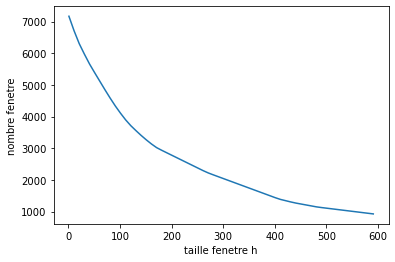

In [10]:
data_ = df_
data = np.array(data_, dtype=np.float64)
start_index = 0
end_index = len(data)
sampling_rate=1 #hour
sequence_length= 10
def len_seq(sequence_length: int = 10):
    # Determine the lowest dtype to store start positions (to lower memory usage).
    num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1

    if num_seqs < 2147483647:
        index_dtype = "int32"
    else:
        index_dtype = "int64"
    # arnaud: custom starting position
    interval = sampling_rate * sequence_length
    stop_indexes = data_[data_["filter"] == 1].index
    id_s = data_.index.difference(data_[data_["filter"] == 1].index)

    start_positions = []
    for slicer in range(len(id_s) - interval):
        # check if continuous
        if id_s[slicer + interval] - id_s[slicer] == interval:
            start_positions.append(id_s[slicer])
    start_positions = np.array(start_positions, dtype=index_dtype)
    return len(start_positions)

x = np.arange(1,600, 10)
plt.plot(x, [len_seq(k) for k in x])
plt.ylabel("nombre fenetre")
plt.xlabel("taille fenetre h")

In [45]:
from library import WindowGenerator, do_datasets

df, df_mean, df_std = do_datasets(data=df_, unscale_cols=["filter"])

WIN_LENGTH = 24 * 5
batch_size = 128

window = WindowGenerator(
    input_width=2*WIN_LENGTH,
    label_width=WIN_LENGTH,
    shift=24 * 5,
    df=df,
    df_mean=df_mean,
    df_std=df_std,
    feature_columns=[
        "Débit horaire",
        "Taux d'occupation",
        "Etat trafic",
        "daySin",
        "weekSin",
        "tempC",
        "visibility",
    ],
    filter_col="filter",
    label_columns=["Débit horaire"],
    batch_size=batch_size,
    train_split=0.7,
    sampling_rate=1,
    shuffle_windows=False,
)

window

/Users/arnaudpetit/Documents/Programmation/3A/datathon_gamma_livraisonCO/library/data/pipeline.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, transform_cols] = (df.loc[:, transform_cols] - df_mean) / df_std


Total window size: 360
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [46]:
len(window.train) #cest pas du nargilez

9

In [ ]:
OUTSTEPS = WIN_LENGTH
num_labels = 1

import tensorflow as tf

lstm_generator = lambda multipl: lambda: tf.keras.Sequential(
    [
        tf.keras.layers.LSTM(int(OUTSTEPS * num_labels * multipl), return_sequences=False)
        for _ in range(1)
    ]
    + [
        tf.keras.layers.Dense(OUTSTEPS * num_labels),
        tf.keras.layers.Reshape([OUTSTEPS, num_labels]),
    ]
)

optimizer = tf.optimizers.Adam()
callback_mod = "EarlyStopping"   
loss_mod = 'mae'#hparams[HP_LOSS]
model_generator = lstm_generator(5)

model_name = "final_model"

val_performance = {}
cli = {}


## Moyenne mobile du débit horaire sur fenêtre de 24h

In [ ]:
from datetime import datetime
mobile_mean = df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"].diff(24).dropna().rolling(24, center=True, min_periods=1).mean()
df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"].diff().dropna().plot(figsize=(10,4), label = 'Débit horaire')
mobile_mean.plot(figsize=(10,4), color='coral', label = 'Moyenne mobile du débit horaire')
plt.legend()
plt.show()

## Moyenne mobile du taux d'occupation sur fenêtre de 24h

## Grid search sur les paramètres de SARIMA

In [ ]:
df_train_ce = set_indexes_for_timeseries(df_train_ce)
plt.rcParams["figure.figsize"] = (20,8)
decomposition = sm.tsa.seasonal_decompose(df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"].diff(24).dropna(), model='additive')
fig = decomposition.plot()
plt.show()


In [ ]:
from datetime import datetime
plot_acf(df_train_ce["Débit horaire"].diff().diff(24).dropna(),lags=50)
plot_pacf(df_train_ce["Débit horaire"].diff().diff(24).dropna(),lags=100)

In [ ]:
plot_acf(df_train_ce[df_train_ce["Date"]>datetime(2022,9,1).date()]["Débit horaire"].diff().dropna(),lags=150)
plot_pacf(df_train_ce[df_train_ce["Date"]>datetime(2022,9,1).date()]["Débit horaire"].diff().dropna(),lags=100)

In [ ]:
plot_acf(df_train_ce[df_train_ce["Date"]>datetime(2022,9,1).date()]["Débit horaire"].diff(24).dropna(),lags=[24*i for i in range(5)])
plot_pacf(df_train_ce[df_train_ce["Date"]>datetime(2022,9,1).date()]["Débit horaire"].diff(24).dropna(),lags=[24*i for i in range(5)])

In [ ]:
result = adfuller(df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"].diff(24).dropna())
print('p-value : ', result[1])

In [ ]:
result = adfuller(df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"])
print('p-value : ', result[1])

result = adfuller(df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"].diff().dropna())
print('p-value : ', result[1])


- on choisit d = 1
- on choisit p = 1 
- on choisit q  = 2
- on choisit m = 24 
- on choisit P = 0
- on choisit Q = 2
- on choisit D= 1

In [ ]:
exog_train=df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]\
[['Jour férié','Vacances scolaires','Jour de la semaine_0','Jour de la semaine_1','Jour de la semaine_2','Jour de la semaine_3',
'Jour de la semaine_4','Jour de la semaine_5','Jour de la semaine_6','maxtempC',
'mintempC']]
exog_train = exog_train.astype(float)


In [ ]:
import time
import numpy as np
from sklearn.metrics import mean_squared_error

p=1
d=1
q=2
m=24
P=0
D=1
Q= 2
fitting = True
if fitting:
    s = time.time()
    mod = sm.tsa.statespace.SARIMAX(df_train_ce[df_train_ce["Date"]>datetime(2022,9,1).date()]["Débit horaire"],order=(p,q,d),seasonal_order=(P,D,Q,m),enforce_stationarity=False,enforce_invertibility=False,exog=exog_train)
    model = mod.fit()

In [ ]:
df_test_ce = set_indexes_for_timeseries(df_test_ce)
a = df_test_ce.index.min()
b = df_test_ce.index.max()
a,b

In [ ]:
exog_test=df_test_ce\
[['Jour férié','Vacances scolaires','Jour de la semaine_0','Jour de la semaine_1','Jour de la semaine_2','Jour de la semaine_3',
'Jour de la semaine_4','Jour de la semaine_5','Jour de la semaine_6','maxtempC',
'mintempC']]
exog_test = exog_test.astype(float)

In [ ]:
pred = model.predict(start=a,end=b,exog=exog_test)
pred_train = model.predict(start=df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()].index.min(),
                           end=df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()].index.max(),
                           exog = exog_train)
e = time.time()
print(f"Temps d'éxecution: {e-s}")
rmse = round(np.sqrt(mean_squared_error(df_test_ce["Débit horaire"], pred)),1)
print(rmse)
plt.plot(df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"], label='Données')
plt.plot(df_test_ce["Débit horaire"], "--",  label='Target')
plt.plot(pred, label='Prediction')
plt.plot(pred_train, label = 'Prediction train')
plt.xticks(rotation=45)
plt.title(f'Predictions pour Champs Élysées du 22 au 27 Novembre 2020 \n RMSE={rmse}')
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.ar_model import AutoReg
p=3
fitting = True
if fitting:
    s = time.time()
    mod = AutoReg(df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"],lags=3,trend="ct",exog=exog_train)
    model = mod.fit()

In [ ]:
pred = model.predict(start=a,end=b,exog_oos=exog_test)
pred_train = model.predict(start=df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()].index.min(),
                           end=df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()].index.max(),exog=exog_train)
e = time.time()
print(f"Temps d'éxecution: {e-s}")
rmse = round(np.sqrt(mean_squared_error(df_test_ce["Débit horaire"], pred)),1)
print(rmse)
plt.plot(df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"], label='Données')
plt.plot(df_test_ce["Débit horaire"], "--",  label='Target')
plt.plot(pred, label='Prediction')
plt.plot(pred_train, label = 'Prediction train')
plt.xticks(rotation=45)
plt.title(f'Predictions pour Champs Élysées du 22 au 27 Novembre 2020 \n RMSE={rmse}')
plt.legend()
plt.show()


In [ ]:
from pmdarima.arima import auto_arima
model = auto_arima(df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"],
                  start_p=2,
                  max_p=2,
                  seasonal=True,
                  start_P=2,
                start_q=0,
                   max_q=0,
                  max_P=2,
                  start_Q=1,
                  max_Q=3,
                   m=24,
                  stepwise=True)

In [ ]:
from pmdarima.arima import ndiffs, nsdiffs,auto_arima
adf_diffs = ndiffs(df_train_ce[df_train_ce["Date"]>datetime(2022,11,1).date()]["Débit horaire"], alpha=0.05, test='adf', max_d=10)
kpss_diffs = ndiffs(df_train_ce[df_train_ce["Date"]>datetime(2022,11,1).date()]["Débit horaire"], alpha=0.05, test='kpss', max_d=10)

In [ ]:
kpss_diffs, adf_diffs

In [ ]:
D = nsdiffs(df_train_ce[df_train_ce["Date"]>datetime(2022,11,1).date()]["Débit horaire"], m=24, max_D=5, test='ocsb')
D

In [ ]:
results = auto_arima(df_train_ce[df_train_ce["Date"]>datetime(2022,11,1).date()]["Débit horaire"],
                  p=2,
                     d=0,
                q=0,
                     seasonal=True,
                P=2,
                  start_Q=1,
                     D=0,
                  max_Q=5,
                   m=24,
                  stepwise=True)

results.summary()

In [ ]:
import time
import numpy as np
from sklearn.metrics import mean_squared_error

p=1
d=0
q=2
m=24
P=1
D=0
Q= 1
fitting = True
if fitting:
    s = time.time()
    mod = sm.tsa.statespace.SARIMAX(df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"],order=(p,q,d),seasonal_order=(P,D,Q,m),enforce_stationarity=False,enforce_invertibility=False,exog=exog_train)
    model = mod.fit()
    



In [ ]:
#df_test_ce = set_indexes_for_timeseries(df_test_ce)
a = df_test_ce.index.min()
b = df_test_ce.index.max()
a,b

In [ ]:
pred = model.predict(start=a,end=b,exog=exog_test)
pred_train = model.predict(start=df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()].index.min(),
                           end=df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()].index.max(),exog=exog_train)

rmse = round(np.sqrt(mean_squared_error(df_test_ce["Débit horaire"], pred)),1)
print(rmse)
plt.plot(df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"], label='Données')
plt.plot(df_test_ce["Débit horaire"], "--",  label='Target')
plt.plot(pred, label='Prediction')
plt.plot(pred_train, label = 'Prediction train')
plt.xticks(rotation=45)
plt.title(f'Predictions pour Champs Élysées du 27 novembre au 2 Décembre 2022 \n RMSE={rmse}')
plt.legend()
plt.show()


best_score : 236.1, (2,0,0)*(2,1,2)